In [2]:
import os
# import sys
# sys.path.append('/home/qy707/CP4GenerativeModel')

import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl
# from matplotlib.patches import Patch
# from scipy.stats import multivariate_normal
# from matplotlib.ticker import FormatStrFormatter

# from dataset import get_togo_dataset
# from CP_generative import fit_KMeans
# from utility import get_coverage_length_exact_1d

from pathlib import Path

from torch import layout

data_path = Path('../../Data/')

In [3]:
fontsize=36

In [4]:
def load_CP4Gen_computes(output_saving_path, k):

    scores = np.load(output_saving_path / f'CP4Gen_scores_{k}.npy')
    volumes = np.load(output_saving_path / f'CP4Gen_volumes_{k}.npy')
    ks = np.load(output_saving_path / f'CP4Gen_ks_{k}.npy')
    quant_score = np.load(output_saving_path / f'CP4Gen_quant_score_{k}.npy')

    return scores, volumes, ks, quant_score

In [5]:
def load_PCP_computes(output_saving_path):

    scores = np.load(output_saving_path / f'PCP_scores.npy')
    volumes = np.load(output_saving_path / f'PCP_volumes.npy')
    ks = np.load(output_saving_path / f'PCP_ks.npy')
    quant_score = np.load(output_saving_path / f'PCP_quant_score.npy')

    return scores, volumes, ks, quant_score

In [6]:
def get_intervals(radius, centers):
    # centers: (k, 1)
    # radius: scalar or (k, 1)

    n_sample = len(centers)
    if isinstance(radius, float):
        radius = [radius] * n_sample

    I = []
    for j in range(n_sample):
        l = (centers[j] - radius[j])
        u = (centers[j] + radius[j])
        I.append([l, u])

    temp_tuple = I
    temp_tuple.sort(key=lambda interval: interval[0])
    merged = [temp_tuple[0]]
    for current in temp_tuple:
        previous = merged[-1]
        if current[0] <= previous[1]:
            previous[1] = max(previous[1], current[1])
        else:
            merged.append(current)

    return merged

In [7]:
# def get_pred_region_1d(means, covariances, weights, quant_score):
#
#     radius = []
#     k = len(means)
#
#     for i in range(k):
#         sigma = covariances[i][0] ** 0.5
#         radius.append(sigma * np.sqrt( max(0, 2*quant_score - np.log(2*np.pi) - 2*np.log(sigma/weights[i]))))
#
#     volume = get_coverage_length_exact_1d(radius, means)
#     I = get_intervals(radius, means)
#
#     return I, volume

In [8]:
# def collect_intervals(Y_ens, k, quant_score):
#     # Y_ens: (n_batch, n_ens, 1)
#
#     Is = []
#     Vs = []
#
#     for i in range(len(Y_ens)):
#         y_ens = Y_ens[i]
#         means, covariances, weights = fit_KMeans(y_ens, k)
#         I, V = get_pred_region_1d(means, covariances, weights, quant_score)
#
#         Is.append(I)
#         Vs.append(V)
#
#     return Is, Vs

In [9]:
def get_disjoint_interval_num(interval_collec):
    counts = []
    for i in range(len(interval_collec)):
        intervals = interval_collec[i]
        count = len(intervals)
        counts.append(count)
        
    return np.array(counts)

# S-Curve

In [10]:
class Data:
    def __init__(self, dataset_name, k_optimal, n_epoch, n_ens):
        self.dataset_name = dataset_name
        self.k_optimal = k_optimal
        self.n_epoch = n_epoch
        self.n_ens = n_ens

        CP_output_saving_path = data_path/f'flow-matching--dataset={dataset_name}--n_epochs={n_epoch}--CP_type=CP4Gen--n_ens={n_ens}/outputs/'
        self.CP_scores, self.CP_volumes, self.CP_ks, self.CP_quant_score = load_CP4Gen_computes(CP_output_saving_path, k=k_optimal)

        PCP_output_saving_path = data_path/f'flow-matching--dataset={dataset_name}--n_epochs={n_epoch}--n_ens={n_ens}/outputs/'
        self.PCP_scores, self.PCP_volumes, self.PCP_ks, self.PCP_quant_score = load_PCP_computes(PCP_output_saving_path)

        model_path = data_path/f'{dataset_name}'

        self.X_test = np.load(model_path / f'test_conditions.npy')[:, 0, :]
        self.Y_ens_test = np.load(model_path / f'Y_ens_test.npy')[:, :n_ens, :]
        self.Y_test = np.load(model_path / f'Y_test.npy')

        with open(data_path / f'CP_Is_{dataset_name}.pkl', "rb") as file:
            self.CP_Is = pkl.load(file)

        with open(data_path / f'CP_Vs_{dataset_name}.pkl', "rb") as file:
            self.CP_Vs = pkl.load(file)

        with open(data_path / f'PCP_Is_{dataset_name}.pkl', "rb") as file:
            self.PCP_Is = pkl.load(file)

        with open(data_path / f'PCP_Vs_{dataset_name}.pkl', "rb") as file:
            self.PCP_Vs = pkl.load(file)


In [11]:
data_s = Data(dataset_name='s_curve', k_optimal=3, n_epoch=20000, n_ens=30)

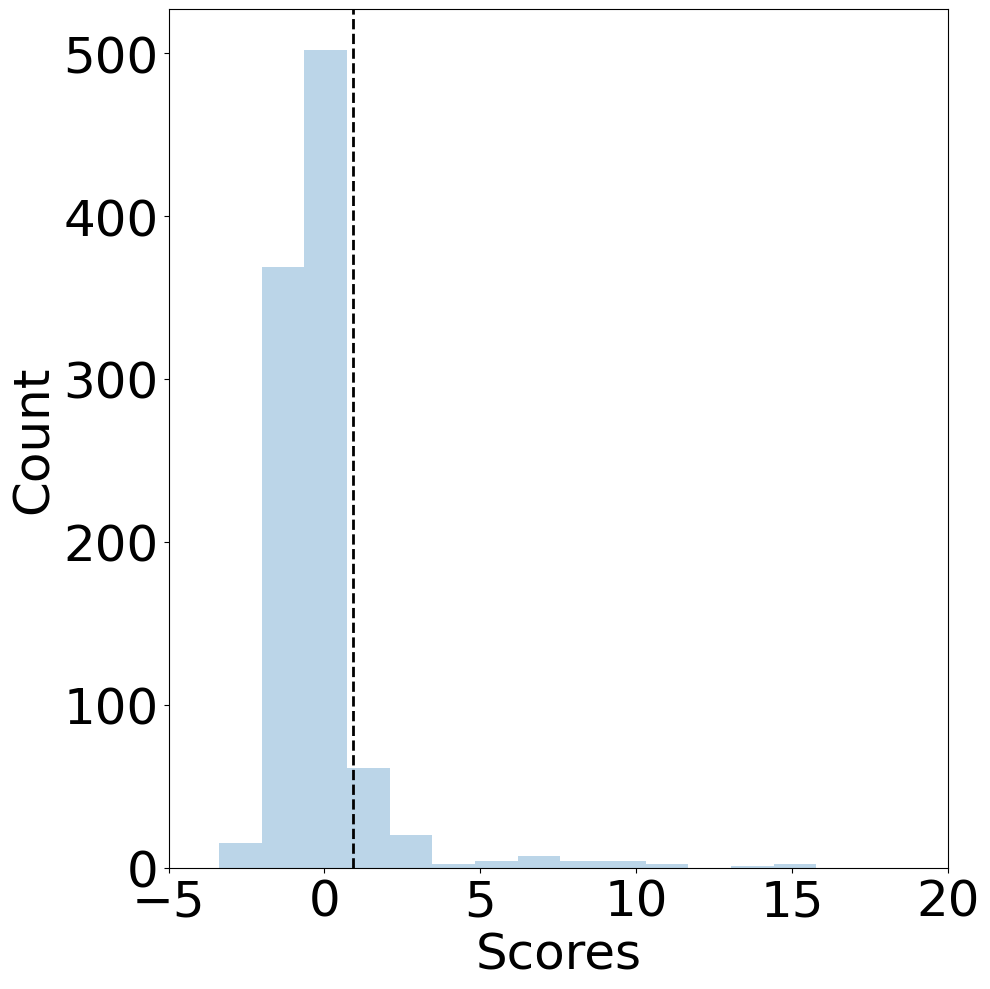

In [14]:
fig, ax = plt.subplots(1, figsize=(10, 10), layout='tight')

ax.hist(data_s.CP_scores, bins=60, color='tab:blue', alpha=0.3)
ax.axvline(np.percentile(data_s.CP_scores, 90), color='black', linestyle='--', linewidth=2)
ax.set_xlim(-5, 20)
ax.set_xlabel('Scores', fontsize=fontsize)
ax.set_ylabel('Count', fontsize=fontsize)
ax.tick_params(axis='both', labelsize=fontsize)

# fig.savefig(f'/scratch/qy707/CP4Gen_Exp/notebooks/plots/scores_hist.png')
fig.savefig('../Overview/scores.pdf', bbox_inches='tight')

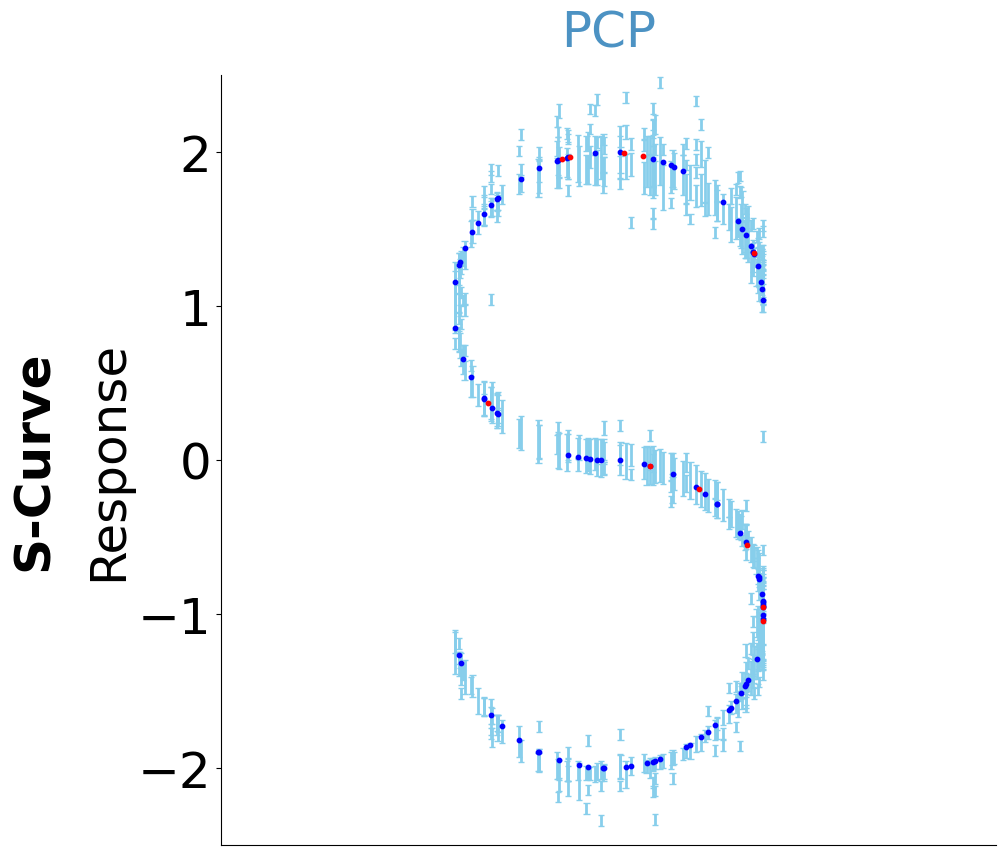

In [54]:
scores = data_s.PCP_scores
intervals = data_s.PCP_Is
quant_score = data_s.PCP_quant_score
cp_name = 'PCP'


tick_width = 0.02
X_uncovered_sub = data_s.X_test[scores >= quant_score][::10]
Y_uncovered_sub = data_s.Y_test[scores >= quant_score][::10]

X_test_sub = data_s.X_test[::10]
Y_test_sub = data_s.Y_test[::10]
intervals_sub = intervals[::10]

fig, ax = plt.subplots(1, figsize=(10, 10))

for i in range(len(X_test_sub)):
    x = X_test_sub[i]
    Is = intervals_sub[i]    
    for I in Is:
        ax.vlines(x, I[0], I[1], color='skyblue', linewidth=2, zorder=0)
        ax.hlines([I[0], I[1]], x - tick_width, x + tick_width, color='skyblue', linewidth=1, zorder=0)


ax.scatter(X_test_sub, Y_test_sub, s=10, color='blue')
ax.scatter(X_uncovered_sub, Y_uncovered_sub, s=10, color='red')

# ax.set_xlim(-1.1, 1.1)
# ax.set_ylim(-2.6, 2.6)
ax.set_xlim(-2.5, 2.5)
ax.set_ylim(-2.5, 2.5)
ax.set_xticks([])
ax.text(-.21, 0.5, 'S-Curve', weight='bold', fontsize=fontsize, horizontalalignment='right', verticalalignment='center', transform=ax.transAxes, rotation=90)
# ax.set_xlabel('Condition', fontsize=fontsize)
# ax.set_yticks(np.arange(-2,3), fontsize=fontsize)
plt.yticks(fontsize=fontsize)
ax.set_ylabel('Response', fontsize=fontsize)
ax.set_title(f'{cp_name}', fontsize=fontsize, pad=20, color='tab:blue', alpha=0.8)

for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

fig.savefig(f'{data_s.dataset_name}_{cp_name}_case_study.pdf', bbox_inches='tight')

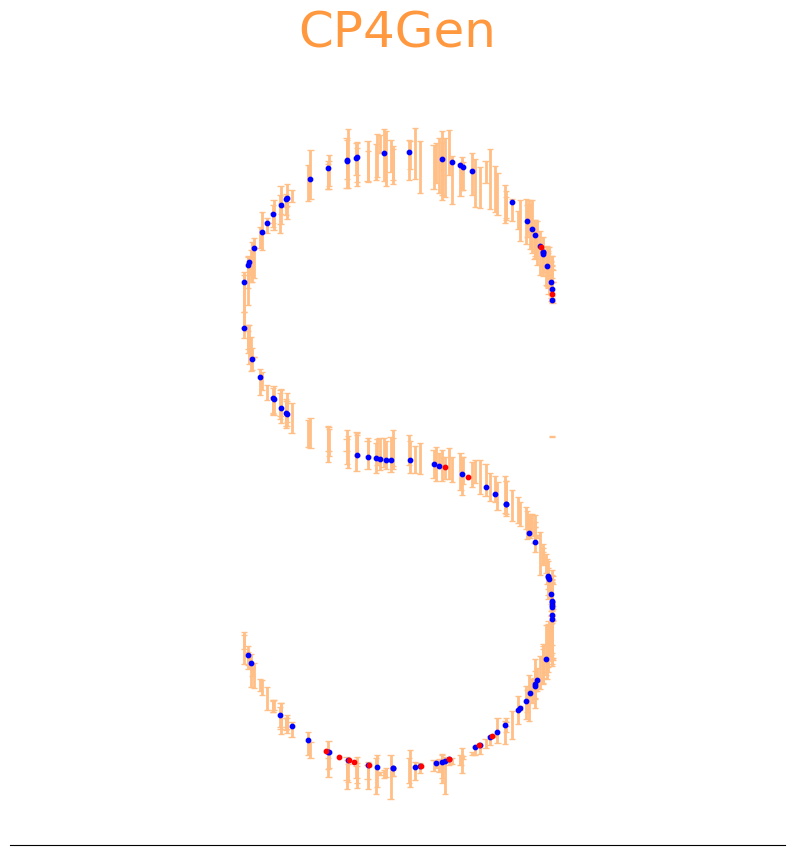

In [55]:
scores = data_s.CP_scores
intervals = data_s.CP_Is
quant_score = data_s.CP_quant_score
cp_name = 'CP4Gen'


tick_width = 0.02
X_uncovered_sub = data_s.X_test[scores >= quant_score][::10]
Y_uncovered_sub = data_s.Y_test[scores >= quant_score][::10]

X_test_sub = data_s.X_test[::10]
Y_test_sub = data_s.Y_test[::10]
intervals_sub = intervals[::10]

fig, ax = plt.subplots(1, figsize=(10, 10))

for i in range(len(X_test_sub)):
    x = X_test_sub[i]
    Is = intervals_sub[i]    
    for I in Is:
        ax.vlines(x, I[0], I[1], color='#FFBF86', linewidth=2, zorder=0)
        ax.hlines([I[0], I[1]], x - tick_width, x + tick_width, color='#FFBF86', linewidth=1, zorder=0)


ax.scatter(X_test_sub, Y_test_sub, s=10, color='blue')
ax.scatter(X_uncovered_sub, Y_uncovered_sub, s=10, color='red')

ax.set_xlim(-2.5, 2.5)
ax.set_ylim(-2.5, 2.5)
# ax.set_xlabel('Condition', fontsize=fontsize)
ax.set_xticks([])
ax.set_yticks([])

# ax.set_ylabel('Response', fontsize=fontsize)
ax.set_title(f'{cp_name}', fontsize=fontsize, pad=20, color='tab:orange', alpha=0.8)

for spine in ['top', 'right', 'left']:
    ax.spines[spine].set_visible(False)

fig.savefig(f'{data_s.dataset_name}_{cp_name}_case_study.pdf', bbox_inches='tight')

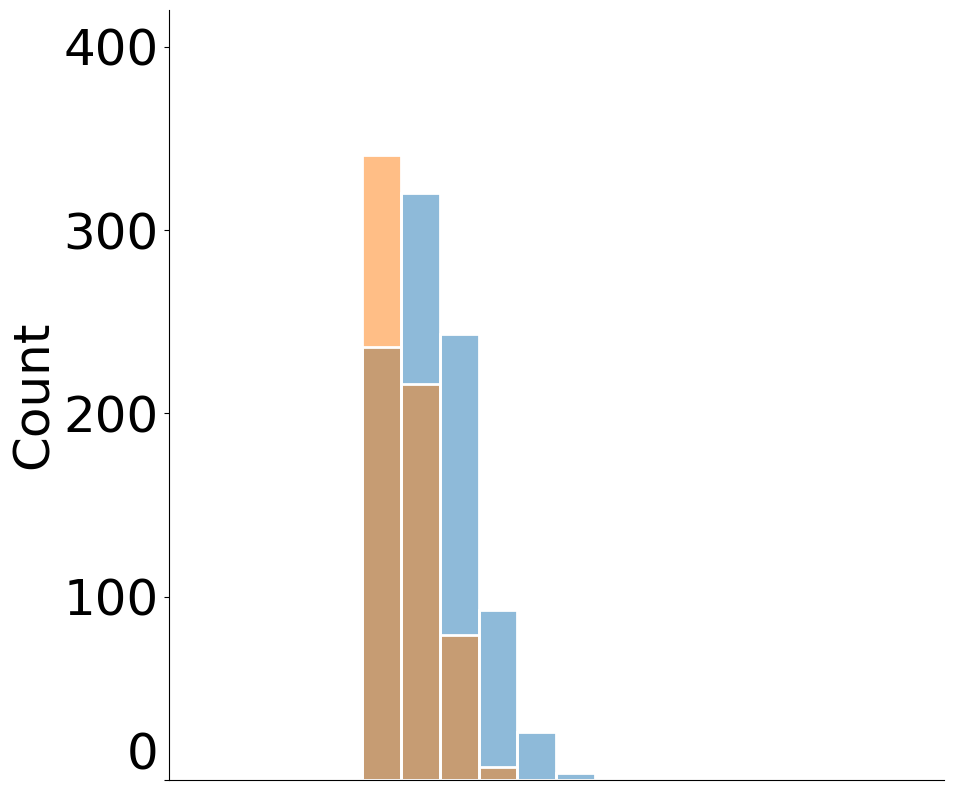

In [56]:
fig, ax = plt.subplots(1, figsize=(10, 10))

_, bins, _ = ax.hist(data_s.PCP_volumes, bins=np.arange(.5, 2, .1), color='tab:blue', alpha=.5, label='PCP', width=.1)
_, bins, _ = ax.hist(data_s.CP_volumes, bins=np.arange(.5, 2, .1), color='tab:orange', alpha=.5, label='CP4Gen', width=.1)

ax.hist(data_s.PCP_volumes, bins=np.arange(.5, 2, .1), width=.1, fc=(0,0,0,0), ec='w', lw=2)
ax.hist(data_s.CP_volumes, bins=np.arange(.5, 2, .1), width=.1, fc=(0,0,0,0), ec='w', lw=2)

# ax.legend(loc='upper right', fontsize=22)
# ax.set_xlabel('Interval Length', fontsize=fontsize)
ax.set_ylabel('Count', fontsize=fontsize)
ax.tick_params(axis='both', labelsize=fontsize)

ax.set_xlim([0, 2])
ax.set_xticks([])
ax.set_ylim([0, 420])
ax.set_yticks(range(0, 500, 100))

# ax.yaxis.tick_right()
# ax.yaxis.set_label_position("right")

ax.get_yticklabels()[0].set_verticalalignment('bottom')
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

fig.savefig(f'{data_s.dataset_name}_length_hist.pdf', bbox_inches='tight')

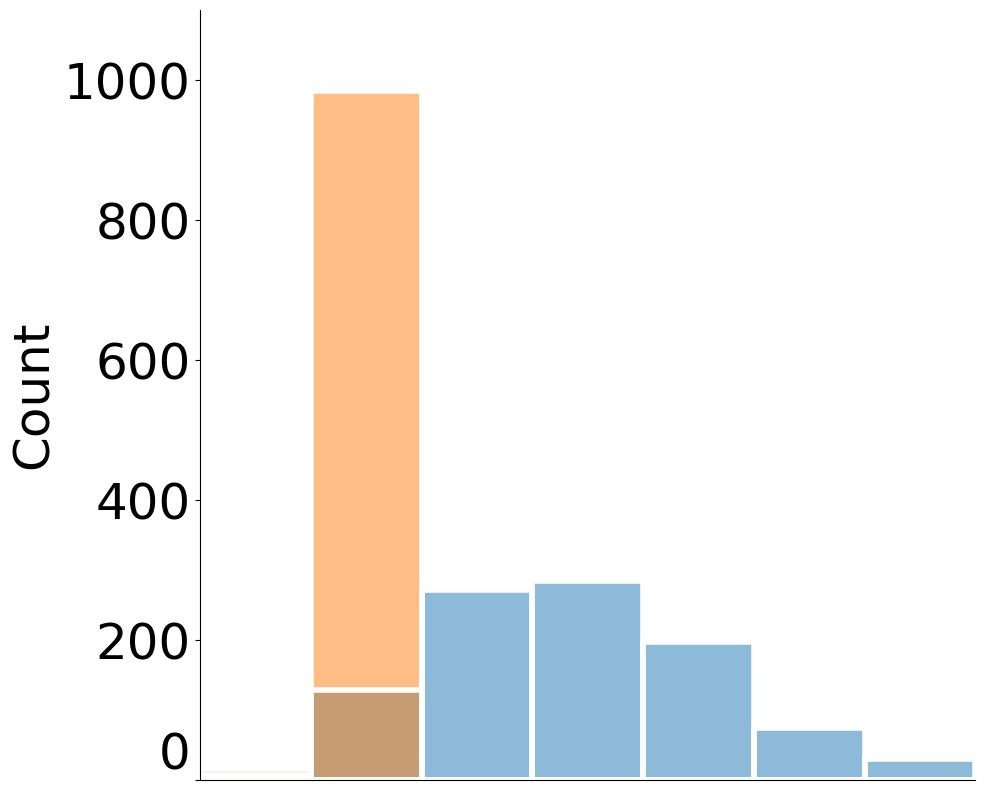

In [57]:
fig, ax = plt.subplots(1, figsize=(10, 10))

_, bins, _ = ax.hist(get_disjoint_interval_num(data_s.PCP_Is), bins=np.arange(1.5, 9.5, 1), color='tab:blue', alpha=0.5, label='PCP', width=1)
_, bins, _ = ax.hist(get_disjoint_interval_num(data_s.CP_Is), bins=np.arange(1.5, 9.5, 1), color='tab:orange', alpha=0.5, label='CP4Gen', width=1)

ax.hist(get_disjoint_interval_num(data_s.PCP_Is), bins=np.arange(1.5, 9.5, 1), width=1, fc=(0,0,0,0), ec='w', lw=4)
ax.hist(get_disjoint_interval_num(data_s.CP_Is), bins=np.arange(1.5, 9.5, 1), width=1, fc=(0,0,0,0), ec='w', lw=4)

# ax.legend(loc='upper right', fontsize=22)
# ax.set_xlabel('Number of Intervals', fontsize=fontsize)
ax.set_ylabel('Count', fontsize=fontsize)
ax.tick_params(axis='both', labelsize=fontsize)

ax.set_xlim([1.5, 8.5])
ax.set_xticks([])
ax.set_ylim([0, 1100])

ax.get_yticklabels()[0].set_verticalalignment('bottom')

for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

fig.savefig(f'{data_s.dataset_name}_num_interval_hist.pdf', bbox_inches='tight')

# 25-Gaussians

In [58]:
data_g = Data(dataset_name='25-Gaussians', k_optimal=5, n_epoch=50000, n_ens=30)

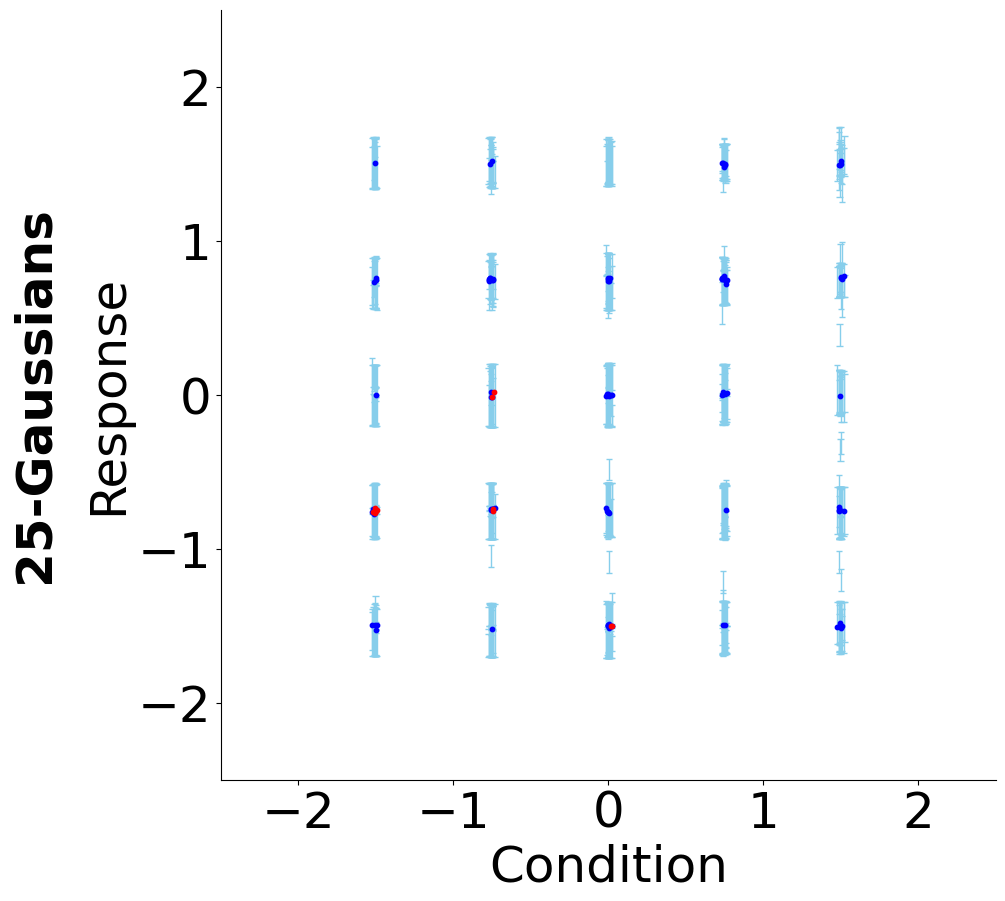

In [59]:
scores = data_g.PCP_scores
intervals = data_g.PCP_Is
quant_score = data_g.PCP_quant_score
cp_name = 'PCP'


tick_width = 0.02
X_uncovered_sub = data_g.X_test[scores >= quant_score][::10]
Y_uncovered_sub = data_g.Y_test[scores >= quant_score][::10]

X_test_sub = data_g.X_test[::10]
Y_test_sub = data_g.Y_test[::10]
intervals_sub = intervals[::10]

fig, ax = plt.subplots(1, figsize=(10, 10))

for i in range(len(X_test_sub)):
    x = X_test_sub[i]
    Is = intervals_sub[i]    
    for I in Is:
        ax.vlines(x, I[0], I[1], color='skyblue', linewidth=1, zorder=0)
        ax.hlines([I[0], I[1]], x - tick_width, x + tick_width, color='skyblue', linewidth=1, zorder=0)

ax.scatter(X_test_sub, Y_test_sub, s=10, color='blue')
ax.scatter(X_uncovered_sub, Y_uncovered_sub, s=10, color='red')

ax.set_xlim(-2.5, 2.5)
ax.set_ylim(-2.5, 2.5)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
ax.set_xlabel('Condition', fontsize=fontsize)
ax.set_ylabel('Response', fontsize=fontsize)
ax.text(-.21, 0.5, data_g.dataset_name, weight='bold', fontsize=fontsize, horizontalalignment='right', verticalalignment='center', transform=ax.transAxes, rotation=90)
# ax.set_xticks(np.arange(-1.5, 2, .5))
# ax.set_yticks(np.arange(-1.5, 2, .5))
# ax.set_title(f'{cp_name}', fontsize=33, pad=10)

for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

fig.savefig(f'{data_g.dataset_name}_{cp_name}_case_study.pdf', bbox_inches='tight')

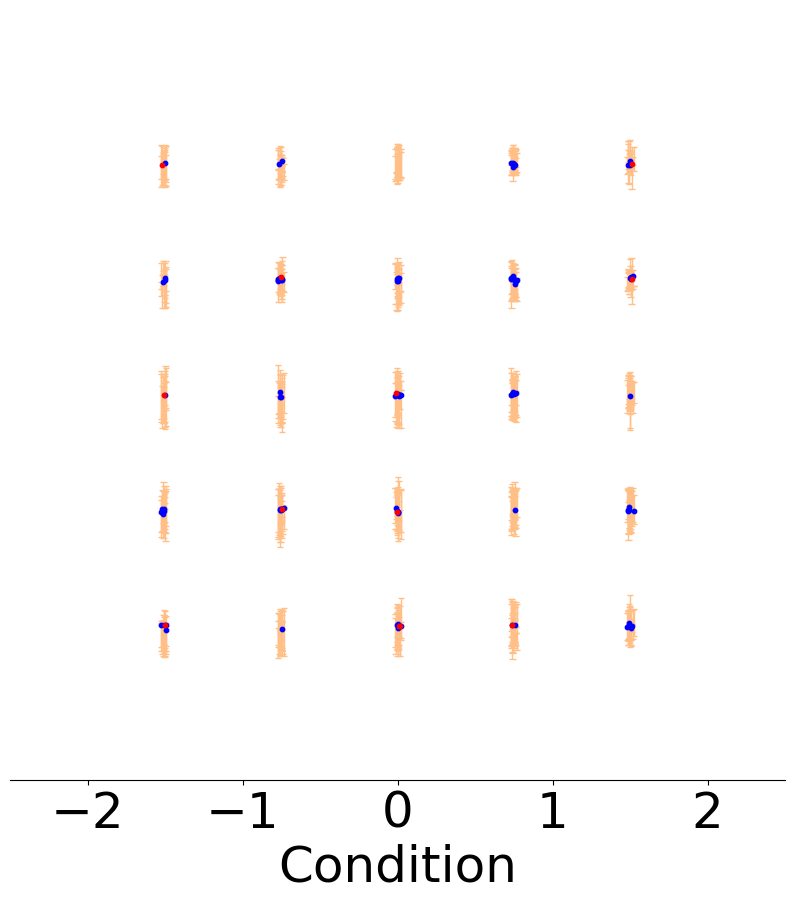

In [60]:
scores = data_g.CP_scores
intervals = data_g.CP_Is
quant_score = data_g.CP_quant_score
cp_name = 'CP4Gen'


tick_width = 0.02
X_uncovered_sub = data_g.X_test[scores >= quant_score][::10]
Y_uncovered_sub = data_g.Y_test[scores >= quant_score][::10]

X_test_sub = data_g.X_test[::10]
Y_test_sub = data_g.Y_test[::10]
intervals_sub = intervals[::10]

fig, ax = plt.subplots(1, figsize=(10, 10))

for i in range(len(X_test_sub)):
    x = X_test_sub[i]
    Is = intervals_sub[i]    
    for I in Is:
        ax.vlines(x, I[0], I[1], color='#FFBF86', linewidth=1, zorder=0)
        ax.hlines([I[0], I[1]], x - tick_width, x + tick_width, color='#FFBF86', linewidth=1, zorder=0)

ax.vlines(x, I[0], I[1], color='#FFBF86', linewidth=1, zorder=0, label='Prediction Set')

ax.scatter(X_test_sub, Y_test_sub, s=10, color='blue', label='Ground Truth Covered')
ax.scatter(X_uncovered_sub, Y_uncovered_sub, s=10, color='red', label='Ground Truth Not Covered')
ax.set_xlim(-2.5, 2.5)

ax.set_xlim(-2.5, 2.5)
ax.set_ylim(-2.5, 2.5)
ax.set_xlabel('Condition', fontsize=fontsize)
# ax.set_ylabel('Response', fontsize=fontsize)
ax.set_yticks([])
plt.xticks(fontsize=fontsize)
# ax.set_title(f'{cp_name}', fontsize=33, pad=10)

# ax.legend(fontsize=fontsize, frameon=False)

for spine in ['top', 'right', 'left']:
    ax.spines[spine].set_visible(False)

fig.savefig(f'{data_g.dataset_name}_{cp_name}_case_study.pdf', bbox_inches='tight')

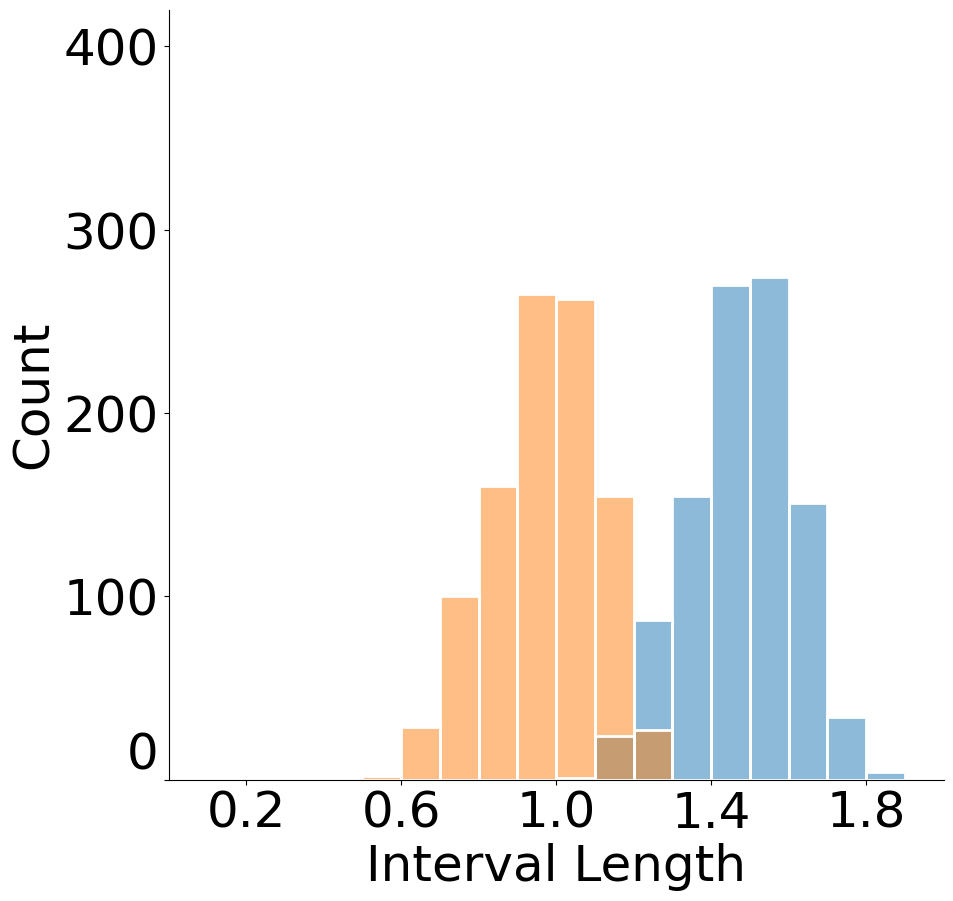

In [61]:
fig, ax = plt.subplots(1, figsize=(10, 10))

_, bins, _ = ax.hist(data_g.PCP_volumes, bins=np.arange(.5, 2, .1), color='tab:blue', alpha=0.5, label='PCP', width=.1)
_, bins, _ = ax.hist(data_g.CP_volumes, bins=np.arange(.5, 2, .1), color='tab:orange', alpha=0.5, label='CP4Gen', width=.1)

ax.hist(data_g.PCP_volumes, bins=np.arange(.5, 2, .1), width=.1, fc=(0,0,0,0), ec='w', lw=2)
ax.hist(data_g.CP_volumes, bins=np.arange(.5, 2, .1), width=.1, fc=(0,0,0,0), ec='w', lw=2)

# ax.legend(loc='upper right', fontsize=fontsize, frameon=False)
ax.set_xlabel('Interval Length', fontsize=fontsize)
ax.set_ylabel('Count', fontsize=fontsize)
ax.tick_params(axis='both', labelsize=fontsize)

ax.set_xlim([0, 2])
ax.set_xticks(np.arange(0.2, 2, .4))
ax.set_ylim([0, 420])
ax.set_yticks(range(0, 500, 100))

# ax.yaxis.tick_right()
# ax.yaxis.set_label_position("right")

ax.get_yticklabels()[0].set_verticalalignment('bottom')
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

fig.savefig(f'{data_g.dataset_name}_length_hist.pdf', bbox_inches='tight')

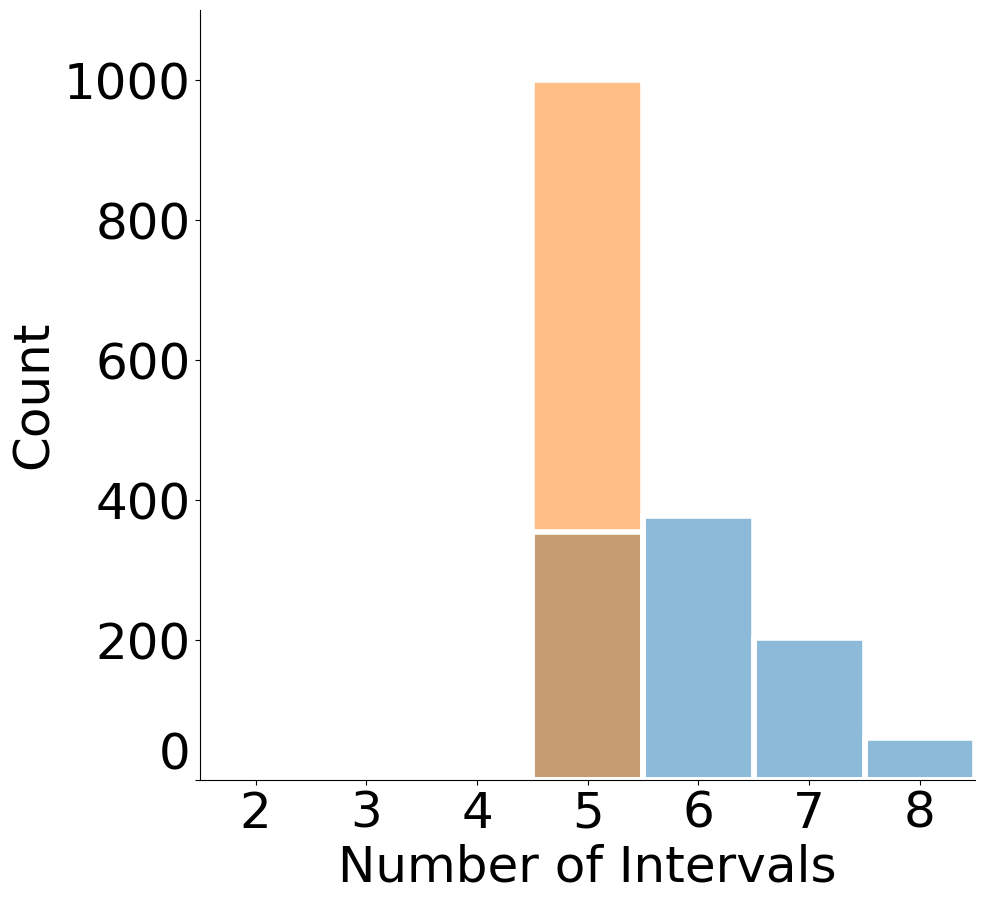

In [62]:
fig, ax = plt.subplots(1, figsize=(10, 10))

n, bins, patches = ax.hist(get_disjoint_interval_num(data_g.PCP_Is), bins=np.arange(1.5, 9.5, 1), color='tab:blue', alpha=0.5, label='PCP', width=1)

n, bins, patches = ax.hist(get_disjoint_interval_num(data_g.CP_Is), bins=np.arange(1.5, 9.5, 1), color='tab:orange', alpha=0.5, label='CP4Gen', width=1)

ax.hist(get_disjoint_interval_num(data_g.PCP_Is), bins=np.arange(1.5, 9.5, 1), width=1, fc=(0,0,0,0), ec='w', lw=4)
ax.hist(get_disjoint_interval_num(data_g.CP_Is), bins=np.arange(1.5, 9.5, 1), width=1, fc=(0,0,0,0), ec='w', lw=4)



ax.set_xlabel('Number of Intervals', fontsize=fontsize)
ax.set_ylabel('Count', fontsize=fontsize)
ax.tick_params(axis='both', labelsize=fontsize)

ax.set_xlim([1.5, 8.5])
ax.set_xticks(np.arange(2, 9, 1))
ax.set_ylim([0, 1100])

ax.get_yticklabels()[0].set_verticalalignment('bottom')
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

fig.savefig(f'{data_g.dataset_name}_num_interval_hist.pdf', bbox_inches='tight')